In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from typing import List
import json
from datetime import datetime

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-4-32cfa6321538>:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions

Predicted class: ДПИ


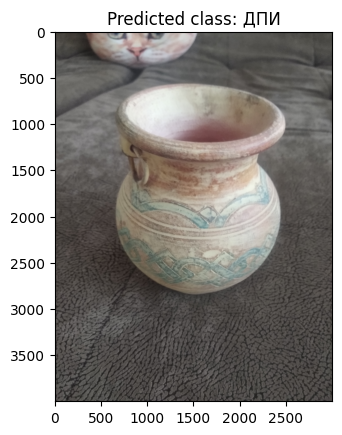

In [ ]:
class ImageClassifier:
    def __init__(self, model_path: str, class_names: List[str], image_size: tuple = (224, 224), device: str = "cuda", save_dir: str = "predictions"):
        self.model_path = model_path
        self.class_names = class_names
        self.image_size = image_size
        self.device = torch.device(device if torch.cuda.is_available() else "cpu")
        self.save_dir = save_dir
        os.makedirs(self.save_dir, exist_ok=True)

        self.transform = transforms.Compose([
            transforms.Resize(self.image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        self.model = self._load_model()
        self.model.eval()

    def _load_model(self) -> nn.Module: #Загрузка обученной модели
        model = models.efficientnet_b0(pretrained=False)
        num_classes = len(self.class_names)
        model.classifier[1] = nn.Linear(1280, num_classes) #Замена последнего слоя
        model.load_state_dict(torch.load(self.model_path, map_location = self.device)) #Загрузка весов с диска
        model = model.to(self.device)
        return model


    def _preprocess_image(self, image_path: str) -> torch.Tensor: #предобработка изображений
        image = Image.open(image_path).resize(self.image_size)
        image = self.transform(image)
        image = image.unsqueeze(0)
        return image.to(self.device)

    def predict_image(self, image_path: str) -> str:
        processed_image = self._preprocess_image(image_path)
        with torch.no_grad():
            output = self.model(processed_image)
            _, predicted = torch.max(output, 1)
            predicted_class_index = predicted.item()
            predicted_class_name = self.class_names[predicted_class_index]
        return predicted_class_name

    def save_prediction(self, image_path: str, predicted_class_name: str):
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        image_name = f"image_{timestamp}.jpg"
        image_path_save = os.path.join(self.save_dir, image_name) # путь сохранения изображения
        Image.open(image_path).save(image_path_save, "JPEG")

        metadata_name = f"metadata_{timestamp}.json"
        metadata_path = os.path.join(self.save_dir, metadata_name) # путь сохранения метаданных
        metadata = {"predicted_class": predicted_class_name, "image_path": image_path_save}
        with open(metadata_path, "w") as file:
            json.dump(metadata, file, indent=4)

    def predict_image_with_plot(self, image_path: str) -> None:  #метод для визуализации тестового изображения и его предсказанного класса
        predicted_class_name = self.predict_image(image_path)
        plt.imshow(Image.open(image_path))
        plt.title(f"Predicted class: {predicted_class_name}")
        plt.show()

if __name__ == "__main__":
    model_path = "/content/best_model.pth"   # путь к модели
    data_dir = "/content/drive/MyDrive/Dataset_all_class"  # путь к датасету с классами(Для получения списка классов)
    class_names = sorted(os.listdir(data_dir))
    image_path = "/content/IMG_20241208_115446.jpg" # путь к тестовому изображению
    save_dir = "/content/output"  # путь сохранения предсказанного класса и переданного изображения

    classifier = ImageClassifier(model_path, class_names, device="cpu", save_dir=save_dir)

    predicted_class = classifier.predict_image(image_path)
    print(f"Predicted class: {predicted_class}")

    classifier.save_prediction(image_path, predicted_class) # Сохраняем результаты
    classifier.predict_image_with_plot(image_path)